In [7]:
!ls data/chest_xray/


__MACOSX
chest_xray
holdout_test
test
train
val


In [56]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from keras.datasets import mnist
from keras import regularizers, initializers, optimizers
import os
import datetime
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

import os
import gc
from timeit import default_timer as timer
os.environ['KMP_DUPLICATE_LIB_OK']='True' #This prevents kernel shut down due to xgboost conflict

In [8]:
train_folder = 'data/chest_xray/train/'
holdout_folder = 'data/chest_xray/val/'
test_folder = 'data/chest_xray/test/'

In [63]:
test_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_folder, batch_size=624, target_size=(255,255), class_mode = 'binary', shuffle = False)

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_folder, batch_size=5232, target_size=(255,255), class_mode = 'binary')

Found 624 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [64]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

0.0


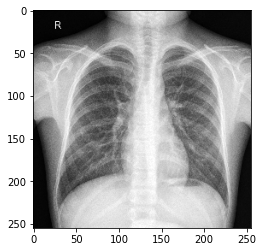

In [65]:
plt.imshow(array_to_img(train_images[0]))
print(train_labels[0])

In [66]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(5216, 255, 255, 3)
(5216,)
(624, 255, 255, 3)
(624,)


In [155]:
X_train = train_images.astype('float32')
X_test = test_images.astype('float32')

In [156]:
X_train.shape

(5216, 255, 255, 3)

In [157]:
X_final_test, X_val, y_final_test, y_val = train_test_split(X_test, test_labels, random_state=42, train_size=.2)

In [187]:
model = Sequential(
    [
        Input((255,255,3)),
        Flatten(), # need to flatten our images to be one long array
        Dense(64,activation="relu"),
        Dense(1, activation="sigmoid"),  #softmax for multiclass target
        
    ])

model.summary()

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_38 (Flatten)         (None, 195075)            0         
_________________________________________________________________
dense_76 (Dense)             (None, 64)                12484864  
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 65        
Total params: 12,484,929
Trainable params: 12,484,929
Non-trainable params: 0
_________________________________________________________________


In [188]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [189]:
batch_size = int(X_train.shape[0]/20)

In [190]:
print(train_images.shape)
print(train_labels.shape)

(5216, 255, 255, 3)
(5216,)


In [191]:
history = model.fit(train_images, 
                    train_labels, 
                    batch_size=batch_size,
                    epochs=5, 
                    validation_data=(X_val, y_val))

Epoch 1/5
21/21 [==============================] - 4s 172ms/step - loss: 17.6267 - accuracy: 0.6093 - val_loss: 0.6101 - val_accuracy: 0.6260
Epoch 2/5
21/21 [==============================] - 3s 154ms/step - loss: 0.6855 - accuracy: 0.7429 - val_loss: 0.6919 - val_accuracy: 0.6260
Epoch 3/5
21/21 [==============================] - 3s 143ms/step - loss: 0.6892 - accuracy: 0.7429 - val_loss: 0.6901 - val_accuracy: 0.6260
Epoch 4/5
21/21 [==============================] - 3s 137ms/step - loss: 0.6855 - accuracy: 0.7429 - val_loss: 0.6882 - val_accuracy: 0.6260
Epoch 5/5
21/21 [==============================] - 3s 125ms/step - loss: 0.6816 - accuracy: 0.7429 - val_loss: 0.6863 - val_accuracy: 0.6260


In [192]:
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

Test loss: 0.6862640380859375
Test accuracy: 0.6259999871253967


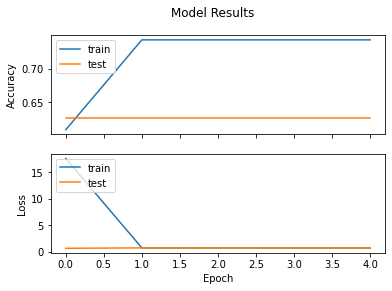

In [193]:
score = model.evaluate(X_val, y_val, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

visualize_training_results(history)


In [202]:
model2 = Sequential()
model2.add(Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape = (255,255,3)))
model2.add(MaxPooling2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(128, activation = 'relu'))
model2.add(Dense(1, activation='sigmoid'))

# compiling models
model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy', 'Recall', 'Precision'])

# early stopping
cp = EarlyStopping(patience = 5, restore_best_weights=True)

model2.summary()

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 255, 255, 32)      896       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
flatten_41 (Flatten)         (None, 516128)            0         
_________________________________________________________________
dense_82 (Dense)             (None, 128)               66064512  
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 129       
Total params: 66,065,537
Trainable params: 66,065,537
Non-trainable params: 0
_________________________________________________________________


In [ ]:

# training
start = timer()

history2 = model2.fit(train_images,
                    train_labels,
                    epochs=20, 
                    validation_data =(X_val,y_val),
                    workers = 7, 
                    callbacks = [cp], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/20
144/163 [=========================>....] - ETA: 16s - loss: 0.5627 - accuracy: 0.8047 - recall: 0.9080 - precision: 0.8416

16/16 [==============================] - 1s 44ms/step - loss: 0.3333 - accuracy: 0.8600 - recall: 0.9329 - precision: 0.8563
Test loss: 0.3333492577075958
Test accuracy: 0.8600000143051147


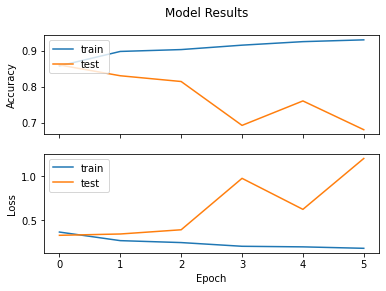

In [197]:
score = model2.evaluate(X_val, y_val, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

visualize_training_results(history2)

In [195]:
def plot_performance(hist):
    hist_ = hist.history
    epochs = hist.epoch
    
    plt.plot(epochs, hist_['accuracy'], label='Training Accuracy')
    plt.plot(epochs, hist_['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, hist_['loss'], label='Training loss')
    plt.plot(epochs, hist_['val_loss'], label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    recall = np.array(hist_['recall'])
    precision = np.array(hist_['precision'])
    val_recall = np.array(hist_['val_recall'])
    val_precision = np.array(hist_['val_precision'])
    plt.figure()
    plt.plot(epochs, 
             2*((recall * precision)/(recall + precision)), 
             label='Training f1')
    plt.plot(epochs, 
             2*((val_recall * val_precision)/(val_recall + val_precision)), 
             label='Validation f1')
    plt.title('Training and validation F1-Score')
    plt.legend()
    
    plt.show()

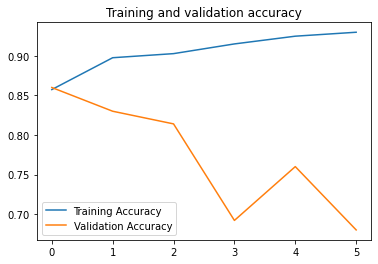

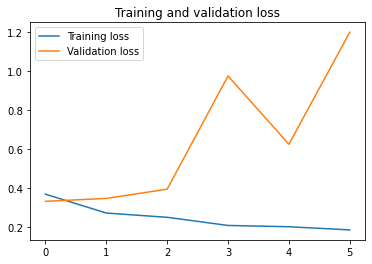

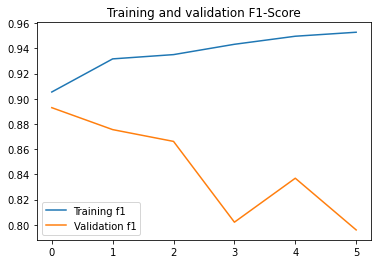

In [196]:
plot_performance(history2)